#

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import solve_discrete_are
%config InlineBackend.figure_formats = ['svg'] 

# Session 1: LQR and Dynamic Programming
## Assignment 1.1

Using infinite horizon K = [[1.28645067 2.31256493]]


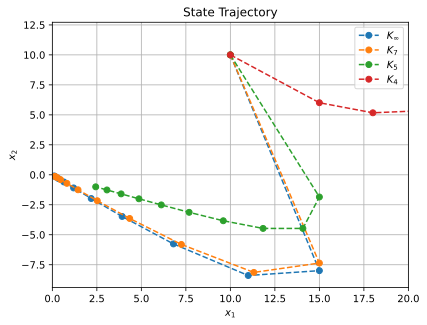

In [ ]:
# discrete time dynamics of the car

Ts = 0.5
A = np.array([[1.0, Ts],[0.0, 1.0]])
B = np.array([[0.0],[-Ts]])
C = np.array([1.0, -2.0/3.0]).reshape([-1,2])
Q = C.T @ C + 0.001 * np.eye(2) 
R = np.array([[0.1]])
Pf = Q 

def dlqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R:np.ndarray) -> tuple[np.ndarray]: 
    """
        Solve the DARE to calculate optimal state feedback gain for infinite horizon LQR
    """
    P = solve_discrete_are(A,B,Q,R)
    K = -np.linalg.solve(R + B.T @ P @ B, B.T @ P @ A)
    return K, P

def dlqr_finite_horizon(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R:np.ndarray, Pf: np.ndarray, N: int) -> tuple[np.ndarray]:
    """
        Solve the Ricatti Recursion to calculate optimal state feedback gain for finite horizon LQR
    """
    P = Pf.copy()
    for k in range(N):
        BTP = B.T@P
        K = np.linalg.solve(R + BTP @ B, -BTP @ A)
        P = Q + A.T @ P @ (A + B @ K)

    return K, P


def simulate(x0: np.ndarray, steps: int, horizon: int, plot = False, label = None) -> tuple[np.ndarray, float]:
    ns = A.shape[0]
    inf_horizon = horizon <= 0
    trajectory = np.zeros([ns, steps+1])
    trajectory[:,0,None] = x0
    x = x0.copy()
    cost = 0

    if inf_horizon:
        K = dlqr(A,B,Q,R)[0]
        policy = lambda x: K @ x
        print(f"Using infinite horizon K = {K}")
    else:
        policy = lambda x: dlqr_finite_horizon(A,B,Q,R,Pf,horizon)[0] @ x

    for i in range(steps):
        u = policy(x)
        cost += 0.5*(x.T @ Q @ x + u.T @ R @ u)
        x = A @ x + B @ u
        trajectory[:,i+1,None] = x

    if plot:
        plt.plot(trajectory[0,:], trajectory[1,:], 'o--', label=label)
        plt.grid(True)
        plt.xlabel(r"$x_1$")
        plt.ylabel(r"$x_2$")
        plt.title("State Trajectory")

    return trajectory, cost 

x0 = np.array([10, 10]).reshape([-1, 1])
simulate(x0, 10, -1, plot=True, label=r"$K_\infty$")
simulate(x0, 10, 7, plot=True, label=r"$K_7$")
simulate(x0, 10, 5, plot=True, label=r"$K_5$")
simulate(x0, 10, 4, plot=True, label=r"$K_4$")
plt.legend()
plt.xlim([0,20])
# plt.savefig("figs/1.1_state_traj.pdf")

## Assignment 1.2

C:\Users\msaad\AppData\Local\Temp\ipykernel_18324\4120107808.py:49: RuntimeWarning: overflow encountered in matmul
  cost += 0.5*(x.T @ Q @ x + u.T @ R @ u)


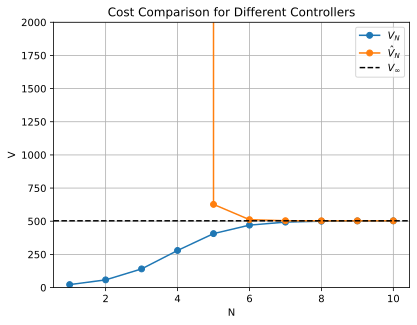

In [ ]:
Vn = []
Vn_inf = []
for N in range(1,11):
    P = dlqr_finite_horizon(A, B, Q, R, Pf, N)[1]
    Vn.append(0.5 * (x0.T @ P @ x0).squeeze())
    Vn_inf.append(simulate(x0,1000,N)[1].squeeze())
P = dlqr(A,B,Q,R)[1]
Vinf = 0.5 * (x0.T @ P @ x0).squeeze()

plt.plot(range(1,11), Vn, 'o-', label=r"$V_N$")
plt.plot(range(1,11), Vn_inf, 'o-', label=r"$\hat{V}_N$")
plt.axhline(Vinf, ls="--", color="k", label=r"$V_\infty$")
plt.grid(True)
plt.ylim([0,2000])
plt.legend()
plt.xlabel("N")
plt.ylabel("V")
plt.title("Cost Comparison for Different Controllers")
# plt.savefig("figs/1.2_cost_compare.pdf")